# Target Brazilian Sales Analysis and Visualization

## Introduction

This project explores Target's operations in Brazil, analyzing 100,000 orders placed between 2016 and 2018. Using SQL and Python, the analysis focuses on sales trends, customer behavior, and product performance. Key insights were drawn from customer and order patterns, pricing trends, and seller performance. 

Advanced SQL queries were utilized to examine revenue by category, seller performance, and customer retention rates. Python libraries such as pandas, matplotlib, and seaborn were employed for data manipulation and visualization, revealing actionable insights to optimize business strategies and improve customer engagement.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="sujin5692001",
    database="ecommerce"
)

cur = conn.cursor()

# List all unique cities where customers are located.

In [5]:
query=""" select distinct geolocation_city 
           from geolocation """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['city'])

df

,city
0,sao paulo
1,sao bernardo do campo
2,jundiaí
3,taboão da serra
4,sãopaulo
...,...
5964,vila langaro
5965,ciriaco
5966,floriano peixoto
5967,erebango


# Count the number of orders placed in 2017.

In [34]:
query=""" select count(order_id) from orders
          where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data=cur.fetchall()

data[0][0]

45101

# Find the total sales per category.

In [49]:
query=""" select p.product_category,round(sum(oi.price),2),count(p.product_category) as units_sold
            from order_items as oi
            join products as p on oi.product_id = p.product_id
            group by  p.product_category  """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data ,columns=['category','total_sales','units_sold'])

df



,category,total_sales,units_sold
0,HEALTH BEAUTY,1258681.34,9670
1,sport leisure,988048.97,8641
2,Cool Stuff,635290.85,3796
3,computer accessories,911954.32,7827
4,Watches present,1205005.68,5991
...,...,...,...
69,flowers,1110.04,33
70,Kitchen portable and food coach,3968.53,15
71,House Comfort 2,760.27,30
72,CITTE AND UPHACK FURNITURE,4368.08,38


# Calculate the percentage of orders that were paid in installments.

In [54]:
query=""" select sum(case when payment_installments>1 then 1 else 0 end)/count(payment_installments)*100
           from payments; """

cur.execute(query)

data=cur.fetchall()

data

[(Decimal('49.4176'),)]

# Find the most frequently used payment method

In [27]:
query="""select payment_type,count(order_id)
        from payments
        group by payment_type;
        """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['payment_method','total_orders'])

df

,payment_method,total_orders
0,credit_card,76795
1,UPI,19784
2,voucher,5775
3,debit_card,1529
4,not_defined,3


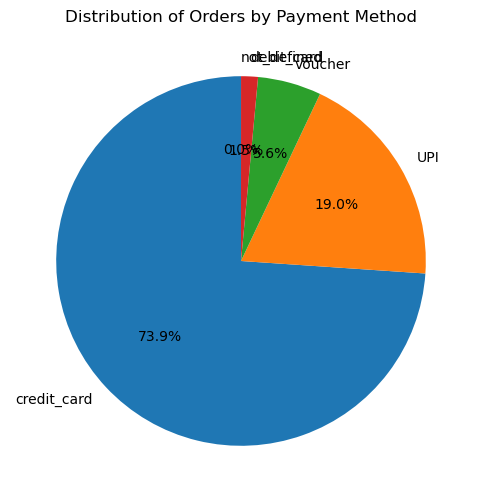

In [45]:
plt.figure(figsize=(6,6))
plt.pie(df['total_orders'], labels=df['payment_method'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Orders by Payment Method')
plt.show()

# Count the number of customers from each state. 


In [11]:
query=""" select customer_state,count(distinct customer_id) as total_customers
        from customers
        group by customer_state;
        """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['state','total_customers'])

df.sort_values(by='total_customers',ascending=False,inplace=True)

df.head(10)

,state,total_customers
25,SP,41746
18,RJ,12852
10,MG,11635
22,RS,5466
17,PR,5045
23,SC,3637
4,BA,3380
6,DF,2140
7,ES,2033
8,GO,2020


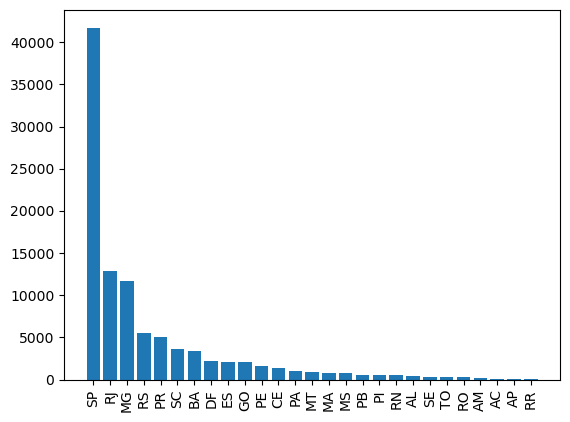

In [13]:
plt.bar(df['state'],df['total_customers'])
plt.xticks(rotation=90)
plt.show()

# calculate the number of orders per month in 2018.


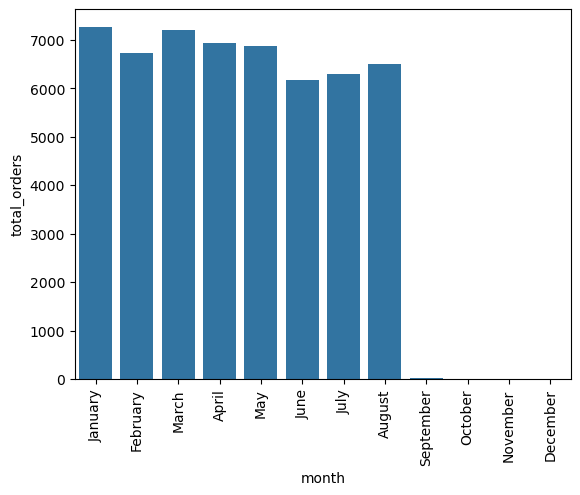

In [94]:
query=""" select year(order_purchase_timestamp) as order_year,monthname(order_purchase_timestamp) as order_month,count(order_id) as total_orders
            from orders
            where year(order_purchase_timestamp) = 2018
            group by year(order_purchase_timestamp) ,monthname(order_purchase_timestamp)
            order by order_month;
        """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['yer','month','total_orders'])
months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]


sns.barplot(data=df,x='month',y='total_orders',order=months)
plt.xticks(rotation=90)
plt.show()

# Calculate the average delivery time by state.

In [62]:
query="""select round(avg(timestampdiff(day, order_purchase_timestamp, order_delivered_customer_date)),0) AS avg_time_taken
        from orders 
        where order_delivered_customer_date is not null;
        """

cur.execute(query)

data=cur.fetchall()

data  # average delivery time of total orders

[(Decimal('12'),)]

In [67]:
query="""select c.customer_state,round(avg(timestampdiff(day, o.order_purchase_timestamp, o.order_delivered_customer_date)),0) AS avg_time_taken
        from orders as o
        join customers  as c on o.customer_id = c.customer_id
        where o.order_delivered_customer_date is not null
        group by c.customer_state;
        """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['state','avg_delivery_time'])

df

,state,avg_delivery_time
0,SP,8
1,PR,12
2,RS,15
3,MG,12
4,BA,19
5,RJ,15
6,DF,13
7,GO,15
8,SC,14
9,PI,19


# Find the average number of products per order, grouped by customer city.

In [103]:
query=""" with cte as(select o.order_id,o.customer_id,count(oi.order_id) as counts,c.customer_city
        from order_items oi
        join orders o on o.order_id = oi.order_id
        join customers c on o.customer_id =c.customer_id
        group by o.order_id,o.customer_id,c.customer_city)
        select customer_city,round(avg(counts),2) as ang_counts
        from cte
        group by customer_city;
        """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['city','avg_orders'])

df
                             

,city,avg_orders
0,anapolis,1.13
1,sao paulo,1.16
2,brasilia,1.13
3,belo horizonte,1.14
4,lagoa santa,1.12
...,...,...
4105,garruchos,1.00
4106,humberto de campos,1.00
4107,bela vista do maranhao,1.00
4108,cantanhede,1.00


# Calculate the percentage of total revenue contributed by each product category.

In [111]:
query="""with cte as(select p.product_category,round(sum(oi.price),2) as total
        from order_items as oi
        join products as p on oi.product_id = p.product_id
        group by  p.product_category)
        select product_category,round((total/sum(total) over())*100,2)
        from cte;
                """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['city','avg_orders'])

df

,city,avg_orders
0,HEALTH BEAUTY,9.26
1,sport leisure,7.27
2,Cool Stuff,4.67
3,computer accessories,6.71
4,Watches present,8.87
...,...,...
69,flowers,0.01
70,Kitchen portable and food coach,0.03
71,House Comfort 2,0.01
72,CITTE AND UPHACK FURNITURE,0.03


# Identify the correlation between product price and the number of times a product has been purchased.

In [119]:
query="""select p.product_category,oi.price,count(oi.price)
        from order_items as oi
        join products as p on oi.product_id = p.product_id
        group by p.product_category,oi.price;
                        """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['product_category','price','count'])

df


,product_category,price,count
0,HEALTH BEAUTY,145.95,3
1,sport leisure,99.90,139
2,sport leisure,99.00,101
3,Cool Stuff,25.00,33
4,sport leisure,390.00,11
...,...,...,...
17871,foods,70.00,1
17872,Fashion Underwear and Beach Fashion,27.90,1
17873,General Interest Books,54.90,1
17874,Cool Stuff,163.90,1


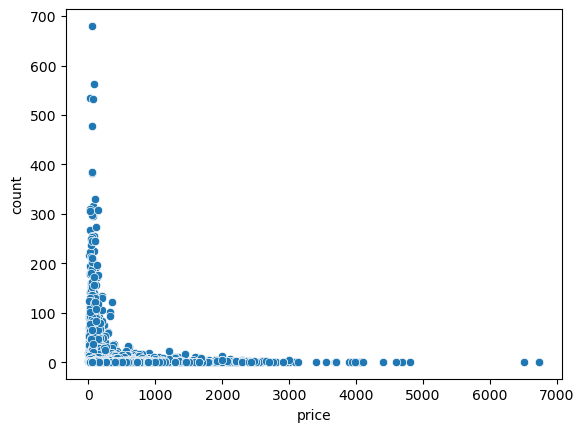

In [121]:
sns.scatterplot(data=df,x='price',y='count')
plt.show()

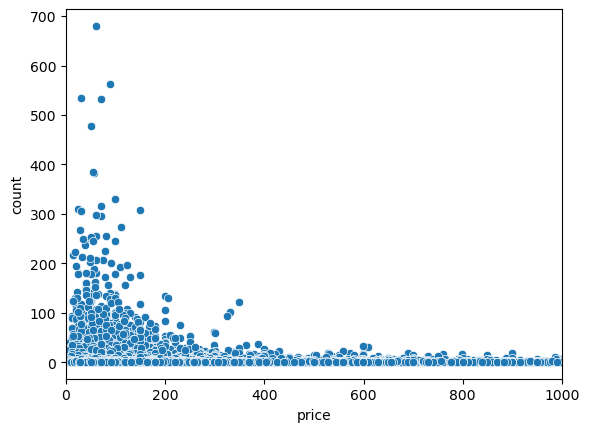

In [125]:
sns.scatterplot(data=df,x='price',y='count')
plt.xlim(0,1000)
plt.show()

#  Calculate the total revenue generated by each seller, and rank them by revenue.


In [131]:
query=""" select seller_id,round(sum(price),2) as total_revenue
        from order_items
        group by seller_id
        order by total_revenue desc; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['seller_id','total_revenue'])
df

,seller_id,total_revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63
1,53243585a1d6dc2643021fd1853d8905,222776.05
2,4a3ca9315b744ce9f8e9374361493884,200472.92
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.03
4,7c67e1448b00f6e969d365cea6b010ab,187923.89
...,...,...
3090,34aefe746cd81b7f3b23253ea28bef39,8.00
3091,702835e4b785b67a084280efca355756,7.60
3092,1fa2d3def6adfa70e58c276bb64fe5bb,6.90
3093,77128dec4bec4878c37ab7d6169d6f26,6.50


# Calculate the moving average of order values for each customer over their order history.

In [7]:
query=""" with cte as (select c.customer_id,o.order_purchase_timestamp,p.payment_value
        from customers as c
        join orders as o on c.customer_id = o.customer_id
        join payments as p on o.order_id = p.order_id)
        select *,round(avg(payment_value)
        over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row),2) as mov_avg
        from cte;
        """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['customer_id','purchase_date','price','mov_avg'])

df

,customer_id,purchase_date,price,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# Calculate the cumulative sales per month for each year.

In [11]:
query="""select distinct year(o.order_purchase_timestamp) as year_,
        month(o.order_purchase_timestamp) as month_,round(sum(p.payment_value) 
        over (partition by year(o.order_purchase_timestamp) order by month(o.order_purchase_timestamp)),2) as cumulative_sales
        from orders as o
        join payments as p on o.order_id = p.order_id
        """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['year','month','cummulative_sum'])

df

,year,month,cummulative_sum
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,138488.04
4,2017,2,430396.05
5,2017,3,880259.65
6,2017,4,1298047.68
7,2017,5,1890966.50
8,2017,6,2402242.88
9,2017,7,2994625.80


(array([2015.75, 2016.  , 2016.25, 2016.5 , 2016.75, 2017.  , 2017.25,
        2017.5 , 2017.75, 2018.  , 2018.25]),
 [Text(2015.75, 0, '2015.75'),
  Text(2016.0, 0, '2016.00'),
  Text(2016.25, 0, '2016.25'),
  Text(2016.5, 0, '2016.50'),
  Text(2016.75, 0, '2016.75'),
  Text(2017.0, 0, '2017.00'),
  Text(2017.25, 0, '2017.25'),
  Text(2017.5, 0, '2017.50'),
  Text(2017.75, 0, '2017.75'),
  Text(2018.0, 0, '2018.00'),
  Text(2018.25, 0, '2018.25')])

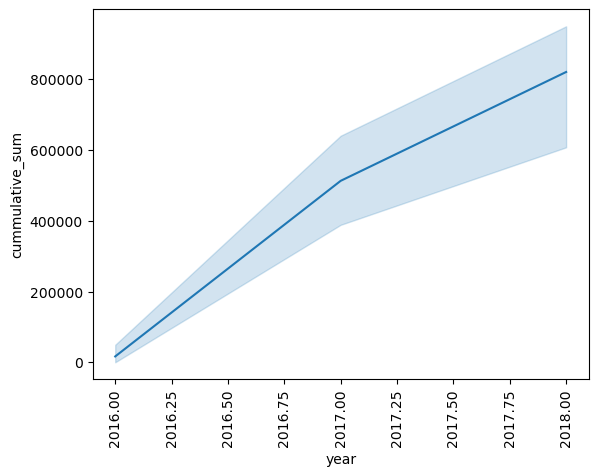

In [9]:
sns.lineplot(data=df,x='year',y='cummulative_sum')
plt.xticks(rotation=90)

# Calculate the year-over-year growth rate of total sales.

In [7]:
query=""" with cte as (select year(o.order_purchase_timestamp) as years,round(sum(oi.price),2) as total
        from order_items as oi
        join orders as o on oi.order_id  = o.order_id
        group by year(o.order_purchase_timestamp)),
        cte2 as (
        select years, total,lag(total,1) over (order by years) as lag_total
        from cte)
        select years,round(((total-lag_total)/lag_total)*100,2) as yoy_growth_rate
        from cte2; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['year','yoy_growth_rate'])

df

,year,yoy_growth_rate
0,2016,NaN
1,2017,12264.55
2,2018,19.99


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [18]:
query=""" select round(((with cte as (select distinct customer_id,order_purchase_timestamp,
        row_number() over (partition by customer_id order by order_purchase_timestamp) as ranks
        from orders),
        cte_2 as (
        select cte1.customer_id,cte2.order_purchase_timestamp - cte1.order_purchase_timestamp as time_diff
        from cte as cte1
        join cte as cte2 on cte1.customer_id = cte2.customer_id
        and cte1.ranks = 1
        and cte2.ranks = 2)
        select count(customer_id) from cte_2)/count(distinct customer_id))*100,2) as retention_rate 
        from orders;
        """

cur.execute(query)

data=cur.fetchall()

data

[(Decimal('0.00'),)]

# Identify the top 3 customers who spent the most money in each year.

In [22]:
query=""" with cte as (select o.customer_id,year(o.order_purchase_timestamp) as years,round(sum(p.payment_value),2) as total_spent,
        dense_rank() over (partition by year (o.order_purchase_timestamp) order by round(sum(p.payment_value),2) desc) as ranks
        from orders as o
        join payments as p on o.order_id = p.order_id
        group by o.customer_id,year(o.order_purchase_timestamp))
        select customer_id,years,total_spent
        from cte 
        where ranks in (1,2,3);"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['customer_id','year','total_spent'])

df

,customer_id,year,total_spent
0,a9dc96b027d1252bbac0a9b72d837fc6,2016,1423.55
1,1d34ed25963d5aae4cf3d7f3a4cda173,2016,1400.74
2,4a06381959b6670756de02e07b83815f,2016,1227.78
3,1617b1357756262bfa56ab541c47bc16,2017,13664.08
4,c6e2731c5b391845f6800c97401a43a9,2017,6929.31
5,3fd6777bbce08a352fddd04e4a7cc8f6,2017,6726.66
6,ec5b2ba62e574342386871631fafd3fc,2018,7274.88
7,f48d464a0baaea338cb25f816991ab1f,2018,6922.21
8,e0a2412720e9ea4f26c1ac985f6a7358,2018,4809.44


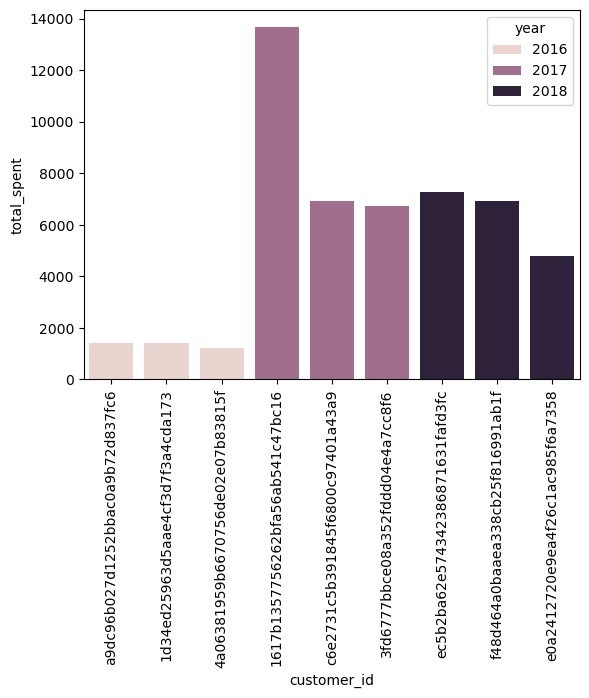

In [28]:
sns.barplot(data=df,x='customer_id',y='total_spent',hue='year')
plt.xticks(rotation = 90)
plt.show()

# Findings and Conclusion

### Geographical Distribution
- The analysis revealed that **SP** had the highest number of customers with **41,746**, and **RJ** and **MG** had the second and third most customers with **12,852** and **11,635** customers, respectively, contributing significantly to total sales.
- Customer segmentation based on location helped identify regions with potential for targeted marketing.

### Sales Performance
- The analysis of sales data showed that **Health & Beauty** was the most popular category, with **9,670** units sold, generating a total revenue of **1,258,681.34**.

### Customer Behavior
- Additionally, **Credit Card** was identified as the most frequently used payment method, accounting for **73.9%** of transactions.

### Delivery Timeliness
- The average delivery time was calculated to be **12 days**, with some orders delivered earlier or later than the estimated delivery date.
- Factors such as customer location and product type impact#ed del



## The analysis provided actionable insights into customer behavior, sales trends, and delivery performance. These findings could help Target improve      its marketing strategies, optimize inventory management, and enhance customer satisfaction by reducing delivery delays.ry times.
s.
